**Part of PCAR Toolbox for GNU Octave, Matlab, and Python**

*Distributed with the GNU GPLv3 license*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Get data

In [2]:
filename = Path('../../data/Eawag_dataset2.csv')
data   = pd.read_csv(filepath_or_buffer=filename,delimiter  =',',header=0)
X = data.iloc[:,4:54].values
volNO2 = data['NO_2-N stock [mL]'].values
volNO3 = data['NO_3-N stock [mL]'].values
yNO2 = data['mgNO_2-N/L'].values
yNO3 = data['mgNO_3-N/L'].values

print('Input shape:', X.shape)
print('Output(s) shape', yNO3.shape)

Input shape: (256, 50)
Output(s) shape (256,)


# Having a look at the data

Two plots are created:
* One plot with nitrite and nitrate concentrations
* One plot with spectra

In both plots, the blue color indicates data corresponding the highest nitrate concentration. The red color indicate data corresponding to the highest nitrite concentration.

<IPython.core.display.Javascript object>


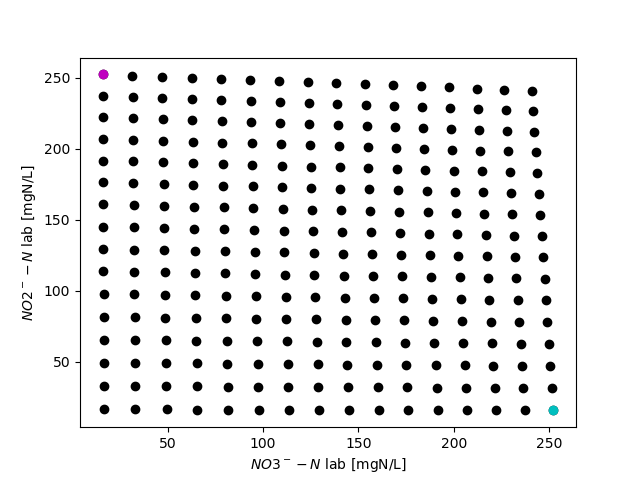

<IPython.core.display.Javascript object>


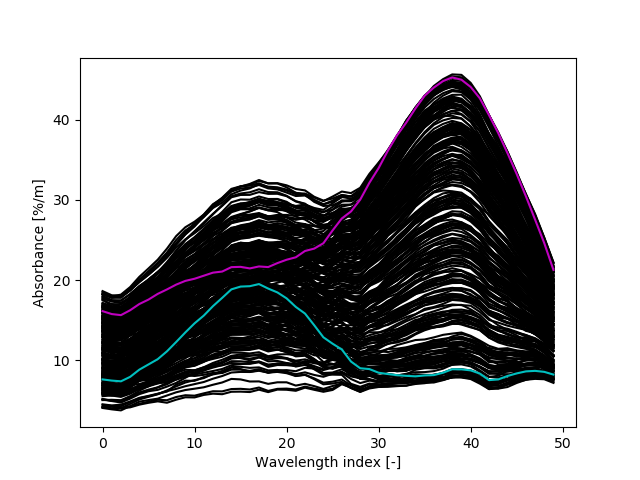

In [3]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)
ax.plot(yNO3,yNO2,marker='o',linestyle='none',color='k')

indexmaxNO3 = np.where(yNO3==np.max(yNO3))[0];
ax.plot(yNO3[indexmaxNO3],yNO2[indexmaxNO3],marker='o',linestyle='none',color='c')
indexmaxNO2 = np.where(yNO2==np.max(yNO2))[0];
ax.plot(yNO3[indexmaxNO2],yNO2[indexmaxNO2],marker='o',linestyle='none',color='m');
ax.set_xlabel('$NO3^--N$ lab [mgN/L]')
ax.set_ylabel('$NO2^--N$ lab [mgN/L]')

fig,ax = plt.subplots(1,1)
ax.plot(X.T,color='k');
ax.plot(X[indexmaxNO3,:].T,color='c');
ax.plot(X[indexmaxNO2,:].T,color='m');
ax.set_xlabel('Wavelength index [-]')
ax.set_ylabel('Absorbance [%/m]');
plt.show()

# Split the data into data for calibration/validation and for testing

In [4]:
rCalVal =np.where(np.mod(volNO2+volNO3,4)==0)[0]
rTest =np.where(np.mod(volNO2+volNO3,4)!=0)[0]

<IPython.core.display.Javascript object>


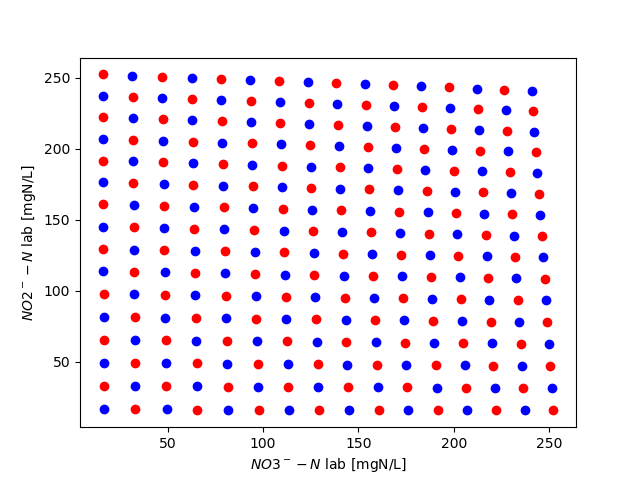

In [5]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)
ax.plot(yNO3[rCalVal],yNO2[rCalVal],marker='o',linestyle='none',color='b')
ax.plot(yNO3[rTest],yNO2[rTest],marker='o',linestyle='none',color='r')
ax.set_xlabel('$NO3^--N$ lab [mgN/L]')
ax.set_ylabel('$NO2^--N$ lab [mgN/L]');

# Principal component regression (PCR)
## PCR - Building one model

We first execute principal component analysis to compress the information in the input into 2 dimensions (2 principal components). The plots below shows the two principal scores with a color reflecting the nitrate (nitrite) concentration.

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X[rCalVal,:])
T =pca.transform(X)

<IPython.core.display.Javascript object>


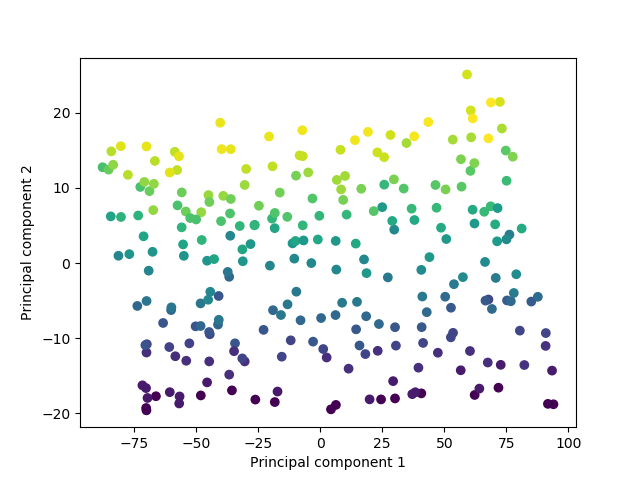

<IPython.core.display.Javascript object>


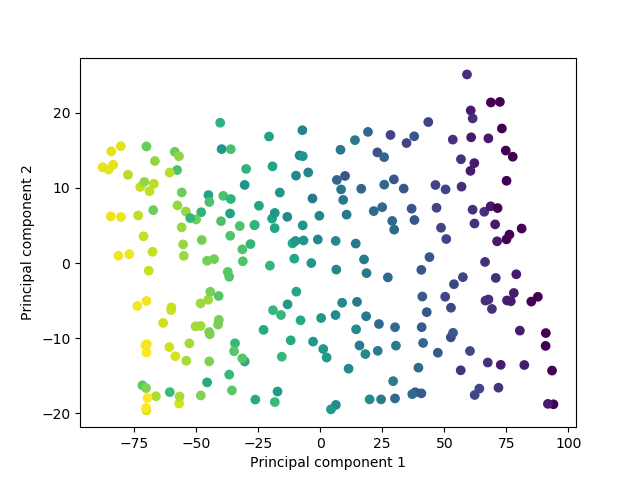

In [7]:
%matplotlib notebook
fig,ax = plt.subplots(1,1)
ax.scatter(T[:,0],T[:,1],c=yNO3);
ax.set_xlabel('Principal component 1');
ax.set_ylabel('Principal component 2');

fig,ax = plt.subplots(1,1)
ax.scatter(T[:,0],T[:,1],c=yNO2);
ax.set_xlabel('Principal component 1');
ax.set_ylabel('Principal component 2');

We build a regression model with the 2 principal scores as inputs.

In [8]:
T =pca.transform(X)
T1 = np.concatenate((np.ones([256,1]),T),axis=1)
beta = np.dot(np.linalg.pinv(T1[rCalVal,:]),yNO3[rCalVal])
P=pca.components_.T
coef_ = np.dot(P,beta[1:])
yNO3hat = np.dot(T1,beta)

<IPython.core.display.Javascript object>


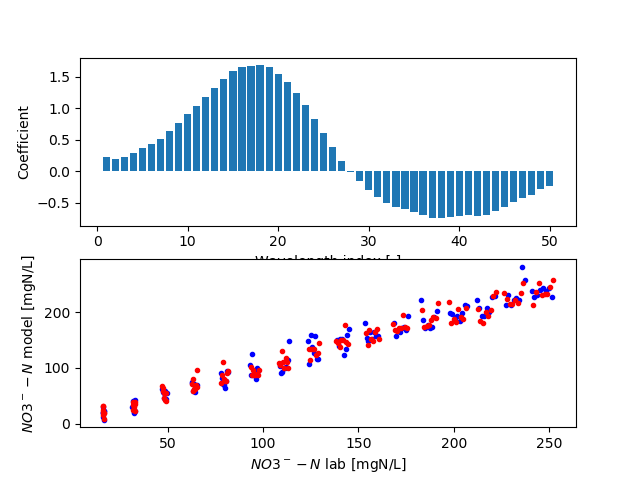

<IPython.core.display.Javascript object>


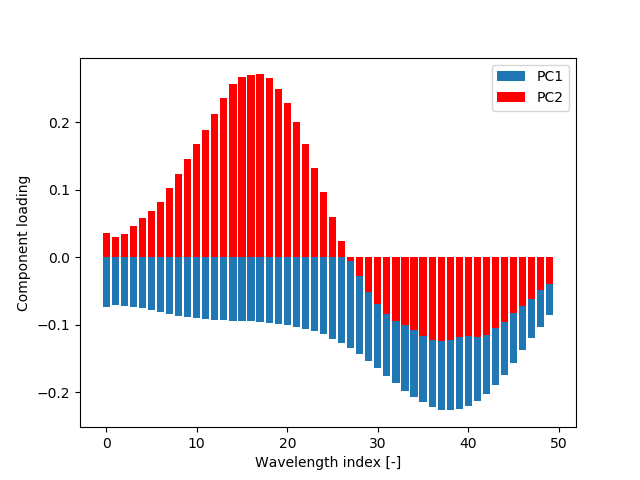

In [9]:
%matplotlib notebook
fig,ax = plt.subplots(2,1)
ax[0].bar(np.arange(50)+1,coef_)
ax[0].set_xlabel('Wavelength index [-]')
ax[0].set_ylabel('Coefficient');
ax[1].plot(yNO3[rCalVal],yNO3hat[rCalVal],marker='.',linestyle='none',color='b');
ax[1].plot(yNO3[rTest],yNO3hat[rTest],marker='.',linestyle='none',color='r');
ax[1].set_xlabel('$NO3^--N$ lab [mgN/L]');
ax[1].set_ylabel('$NO3^--N$ model [mgN/L]');

fig,ax = plt.subplots(1,1)
ax.bar(np.arange(50),P[:,0],label='PC1')
ax.bar(np.arange(50),P[:,1],label='PC2',color='r')
ax.set_xlabel('Wavelength index [-]')
ax.set_ylabel('Component loading');
ax.legend();


## PCR - Leave-One-Out Cross-Validation (LOOCV)

In [10]:
K = 25
M = np.shape(rCalVal)[0] 
import warnings
warnings.simplefilter("ignore")

Error = np.nan*np.ones([M,K])
for r in range(M):
    rVal = rCalVal[r]
    rCal = np.setdiff1d(rCalVal,rVal)
    for k in range(K):
        pca = PCA(n_components=k)
        pca.fit(X[rCal,:])
        Tcal =pca.transform(X[rCal,:])
        Tcal1 = np.concatenate((np.ones([len(rCal),1]),Tcal),axis=1)
        beta = np.dot(np.linalg.pinv(Tcal1),yNO3[rCal])
        
        Tval =pca.transform(X[rVal,:][None,:])
        Tval1 = np.concatenate((np.ones([1,1]),Tval),axis=1)
        yNO3hat = np.dot(Tval1,beta)
        
        Error[r,k] = yNO3hat-yNO3[rVal]

## PCR - Selection with one-standard-deviation rule

The final value for the number of components is selected with the one-standard-deviation rule.

In [11]:
MSR = np.sum(Error**2,axis=0)/M
MSRstddev = np.sqrt(np.sum((Error**2-MSR)**2,axis=0)/M)
RMSR = np.sqrt(MSR)
RMSRplusOneStdDev = np.sqrt(MSR+MSRstddev)

RMSRmin =np.min(RMSR)
indexmin = np.where(RMSRmin==RMSR)[0][0]
indexselect = np.where(RMSR<=RMSRplusOneStdDev[indexmin])[0][0]

print('Minimum cross-validated RMSR:')
print(str(RMSR[indexmin]))
print('Cross-validated RMSR selected model:')
print(str(RMSR[indexselect]))

Minimum cross-validated RMSR:
8.39181488017045
Cross-validated RMSR selected model:
13.653013891147841


<IPython.core.display.Javascript object>


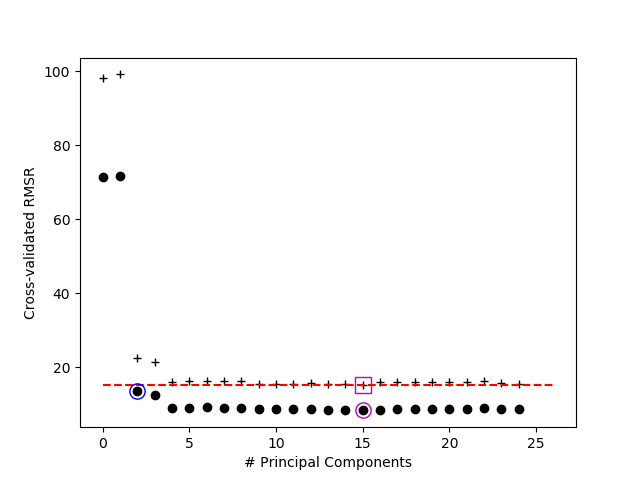

In [12]:
%matplotlib notebook
fig,ax = plt.subplots(1,1)
ax.plot(RMSR,marker='o',linestyle='none',color='k')
ax.plot(RMSRplusOneStdDev,marker='+',linestyle='none',color='k')
ax.plot(indexmin,RMSRmin,marker='o',linestyle='none',color='m',markerfacecolor='none',markersize=11)
ax.plot(indexmin,RMSRplusOneStdDev[indexmin],marker='s',linestyle='none',color='m',markerfacecolor='none',markersize=11)
ax.plot(np.array([0,K+1]),RMSRplusOneStdDev[indexmin]*np.ones([2,1]),linestyle='--',color='r')
ax.plot(indexselect,RMSR[indexselect],marker='o',linestyle='none',color='b',markerfacecolor='none',markersize=11);
ax.set_xlabel('# Principal Components');
ax.set_ylabel('Cross-validated RMSR');

## PCR - show selected model

The selected number of PCs equals 2. This corresponds to the model shown above.